In [21]:
import random
from tensorflow.keras.models import load_model
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from threading import Thread
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201, Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.decomposition import PCA
import joblib
from flask import Flask, request, jsonify
import os
from PIL import Image
import base64
from io import BytesIO
init_notebook_mode(connected=True)

    filename
0  229_1.jpg
1  229_2.jpg
2  229_3.jpg
3  230_1.jpg
4  230_2.jpg
The index of the filename '230_1.jpg' is: 3
dist [[0.         1.89298668 1.95573714 2.01665039 2.02369824 2.21472146]]
index [[  3  23 312 655 243 320]]
F:/python_project/detect_clothing/yolo_by_kaggle/cropped_images2/bag/240_1.jpg
F:/python_project/detect_clothing/yolo_by_kaggle/cropped_images2/bag/345_2.jpg
F:/python_project/detect_clothing/yolo_by_kaggle/cropped_images2/dress/468_1.jpg
F:/python_project/detect_clothing/yolo_by_kaggle/cropped_images2/bag/316_3.jpg
F:/python_project/detect_clothing/yolo_by_kaggle/cropped_images2/bag/348_2.jpg
F:
python_project
detect_clothing
yolo_by_kaggle
cropped_images2
bag
240_1.jpg
cropped_images2\bag\240_1.jpg
F:
python_project
detect_clothing
yolo_by_kaggle
cropped_images2
bag
345_2.jpg
cropped_images2\bag\345_2.jpg
F:
python_project
detect_clothing
yolo_by_kaggle
cropped_images2
dress
468_1.jpg
cropped_images2\dress\468_1.jpg
F:
python_project
detect_clothing
yolo_by

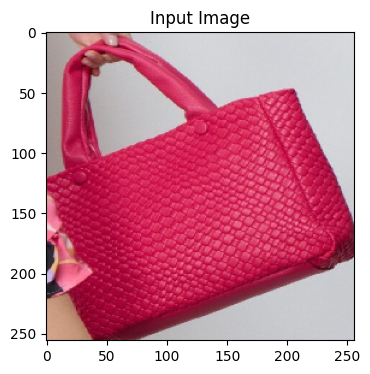

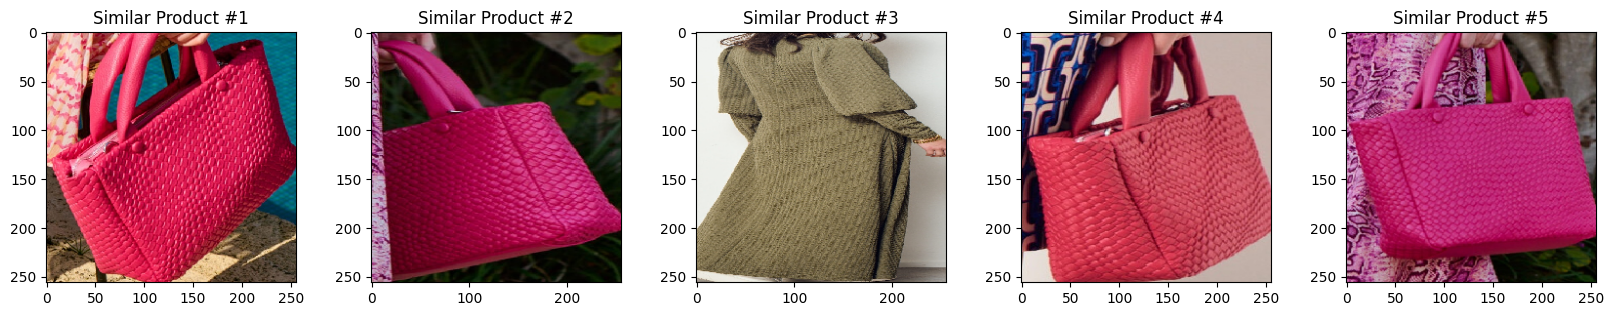

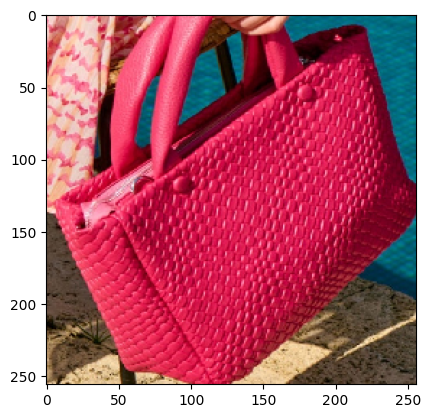

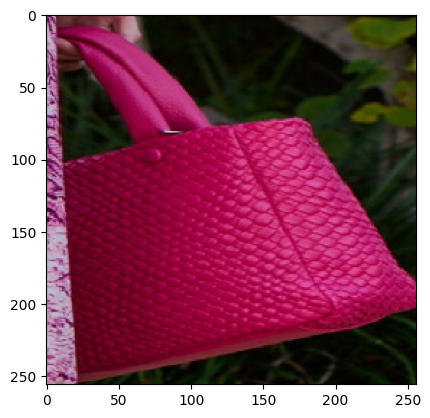

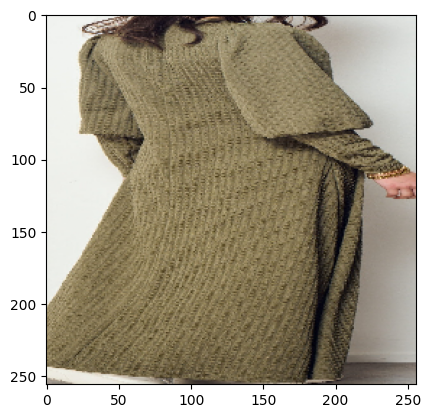

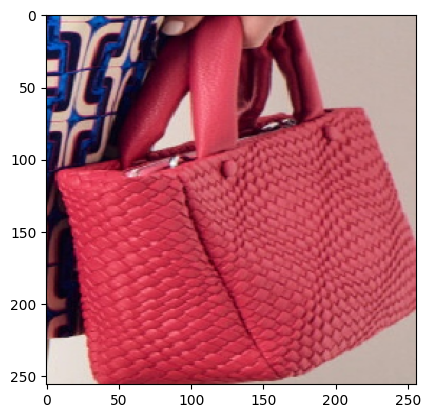

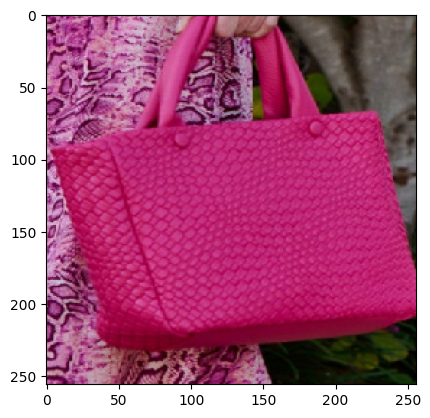

In [20]:



def read_img(image_path):
    image = load_img(image_path,target_size=(256,256,3))
    image = img_to_array(image)
    image = image/255.
    return image

def get_similiar(file_name):
    data = pd.read_csv("./cropp_style.csv")
    data["articleType"]=data['subCategory']
    file_names = data['filename'].apply(os.path.basename)
    new_df = pd.DataFrame(file_names, columns=['filename'])
    # data['only_name'] = data['filename'].apply(os.path.basename)
    print(new_df.head())
        # data_features = saved_model.predict(data_generator,verbose=1)
    data_features=np.load('./data_features.npy')
    # pca = joblib.load('pca_model.pkl')
    pca = PCA()
    pca.fit(data_features)
    data_pca = pca.fit_transform(data_features)[:,:313]
    data_pca = pd.DataFrame(data_pca)
    data = data.iloc[:,0:10]
    data = data.merge(data_pca, how='left', left_index=True, right_index=True)
    Xdata = data.iloc[:,-313:]
    ydata = data['id']
    neigh = KNeighborsClassifier(n_neighbors=6)
    neigh.fit(Xdata, ydata)
    # Load the model
    # saved_model = load_model('vgg16_model.h5')
    # for _ in range(10):
    #     i = random.randint(1,len(data))
    i=0
    names=[]
    if not data[new_df['filename'] == file_name].empty:
        i = data.loc[new_df['filename'] == file_name].index[0]
        print(f"The index of the filename '{file_name}' is: {i}")
        img1 = read_img(data.loc[i,'filename'])
        dist, index = neigh.kneighbors(X=Xdata.iloc[i,:].values.reshape(1,-1))
        plt.figure(figsize = (4 , 4))
        plt.imshow(img1)
        plt.title("Input Image")
        print("dist",dist)
        print("index",index)
        plt.figure(figsize = (20 , 20))
        names=[data.loc[index[0][i],'filename'] for i in range(1,6)]
        for i in range(1,6):
            print(data.loc[index[0][i],'filename'])
            plt.subplot(1 , 5, i)
            plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
            image = read_img(data.loc[index[0][i],'filename'])
            plt.imshow(image)
            plt.title(f'Similar Product #{i}')
    else:
        print(f"The filename '{file_name}' was not found in the DataFrame.")
    return names



In [ ]:
names=get_similiar('230_1.jpg')
images=[]
for name in names:
    parts=name.split('/')
    for part in parts:
        print(part)
    print(os.path.join(*parts[-3:])) 
    plt.figure()
    plt.imshow(read_img(os.path.join(*parts[-3:])))  
    images+=[read_img(os.path.join(*parts[-3:]))] 
print(images)

In [22]:
def get_images_paths(names):
    images=[]
    for name in names:
        parts=name.split('/')
        
        # print(os.path.join(*parts[-3:])) 
        # plt.figure()
        # plt.imshow(read_img(os.path.join(*parts[-3:])))  
        images+=[read_img(os.path.join(*parts[-3:]))] 
    return images

In [25]:

app = Flask(__name__)

def get_images_from_path(name):
    image_list = []
    names=get_similiar(name)
    images_paths=get_images_paths(names)
    for filename in images_paths:
        if filename.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):  # You can add more image extensions if needed
            image_path = filename
            with open(image_path, 'rb') as img_file:
                img = Image.open(img_file)
                img.show()
                buffered = BytesIO()
                img.save(buffered, format=img.format)
                img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
                image_list.append({'filename': filename, 'image': img_str})
    return image_list

@app.route('/get_images', methods=['POST'])
def get_images():
    data = request.json
    path = data.get('path')
    if not path or not os.path.exists(path):
        return jsonify({'error': 'Invalid path'}), 400

    images = get_images_from_path(path)
    print(images)
    return jsonify(images)


if __name__ == '__main__':
    app.run(debug=True)
    


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

In [26]:
%tb


SystemExit: 1